In [45]:
project_path = '/content/drive/MyDrive/Colab Notebooks/polyp segmentation'

In [46]:
# !unzip "/content/drive/MyDrive/Colab Notebooks/polyp segmentation/data/archive.zip" -d "/content/drive/MyDrive/Colab Notebooks/polyp segmentation/data/"

In [47]:
import matplotlib.pyplot as plt
import skimage.io
import numpy as np
import os
import random
import shutil

# example of loading an image with the Keras API
from keras import *
from keras.models import *
from keras.preprocessing import image

from matplotlib.patches import Rectangle
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten,Input, Dense, Activation, BatchNormalization
from keras import applications
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
import tensorflow
# from keras.layers.normalization import BatchNormalization

import keras
from keras import optimizers
from matplotlib import pyplot as plt
from IPython.display import clear_output
from sklearn.metrics import roc_auc_score
from numpy.random import seed
import time, os
from __future__ import with_statement
%matplotlib inline
import keras
from keras.preprocessing.image import load_img, img_to_array
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization
from keras import backend as K
from IPython.display import clear_output
from tensorflow.keras import applications 

from sklearn.metrics import roc_auc_score
from numpy.random import seed
from tensorflow.random import set_seed
import time
from __future__ import with_statement

# plots in jupyter notebooks
%matplotlib inline

In [48]:
# Source dataset: from where to copy the files
sourceFolderClass1 = project_path+ '/cropped/polyps'
sourceFolderClass2 = project_path+ '/cropped/non_polyps'
# Destination folders: splitted dataset in train and validation for polyps and non-polyps
destFolderClass1_tr  = project_path+ '/data/train/polyps'
destFolderClass2_tr  = project_path+ '/data/train/non_polyps'
destFolderClass1_val = project_path+ '/data/validation/polyps'
destFolderClass2_val = project_path+ '/data/validation/non_polyps'

In [49]:
sourceFiles1 = os.listdir(sourceFolderClass1)
sourceFiles2 = os.listdir(sourceFolderClass2)
print("Class 1 - polyps:", len(sourceFiles1))
print("Class 2 - non-polyps:", len(sourceFiles2))

Class 1 - polyps: 606
Class 2 - non-polyps: 606


In [50]:
random.seed(1)
random.shuffle(sourceFiles1)
random.shuffle(sourceFiles2)

In [7]:
# No of file to copy in VALIDATION folder for each class
val_files = 151

# Copy the first 151 files for polyps and non-polyps into validation folders
print('--> Validation split ...')
for i in range(val_files):
    # copy validation polyps
    File1 = os.path.join(sourceFolderClass1,sourceFiles1[i])
    File2 = os.path.join(destFolderClass1_val,  sourceFiles1[i])
    shutil.copy(File1,File2)
    # copy validation non-polyps
    File1 = os.path.join(sourceFolderClass2, sourceFiles2[i])
    File2 = os.path.join(destFolderClass2_val,   sourceFiles2[i])
    shutil.copy(File1, File2)

print('--> Done!')

--> Validation split ...
--> Done!


In [8]:
# Copy polyps to train
print('--> Train split ...')
for i in range(val_files,len(sourceFiles1)):
    File1 = os.path.join(sourceFolderClass1,  sourceFiles1[i])
    File2 = os.path.join(destFolderClass1_tr, sourceFiles1[i])
    shutil.copy(File1,File2)
# copy non-polyps to train
for i in range(val_files,len(sourceFiles2)):    
    File1 = os.path.join(sourceFolderClass2,  sourceFiles2[i])
    File2 = os.path.join(destFolderClass2_tr, sourceFiles2[i])
    shutil.copy(File1, File2)

print('--> Done!')

--> Train split ...
--> Done!


In [51]:
print('--> Dataset: data_polyps')
print('> Train - polyps:', len(os.listdir(destFolderClass1_tr)))
print('> Train - non-polyps:', len(os.listdir(destFolderClass2_tr)))
print('> Validation - polyps:', len(os.listdir(destFolderClass1_val)))
print('> Validation - non-polyps:', len(os.listdir(destFolderClass2_val)))

--> Dataset: data_polyps
> Train - polyps: 455
> Train - non-polyps: 455
> Validation - polyps: 151
> Validation - non-polyps: 151


**CNN**

In [52]:
class PlotLosses(keras.callbacks.Callback):
    # Show the live training and validation loss during the training
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        clear_output(wait=True)
        plt.plot(self.x, self.acc, label="ACC_Train")
        plt.plot(self.x, self.val_acc, label="ACC_Val")
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
                   ncol=2, mode="expand", borderaxespad=0.)
        plt.grid()
        # plt.ylim(0.0, 1.0) # limited Y values to 1.0!
        plt.show()

plot_losses = PlotLosses() # initialize the class

In [53]:
# Dimensions of our images.
img_width, img_height = 150, 150

# Train & validation folders
train_data_dir      =project_path + '/data/train'
validation_data_dir = project_path + '/data/validation'

# Folder to save the models
modelFolder = project_path + '/saved_models'

# Train parameters
nb_train_samples      = 910
nb_validation_samples = 301

In [54]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [106]:
def CNN_3Conv_1FC(convs, dims, epochs, batch_size, drop_rate, input_shape):
    # CNN with 3 Conv + 1 FC
    # convs = no of filters
    # dims = dimension of convolution dims x dims
    # epochs = training epochs
    # batch_size = training batch size
    # input_shape = shape of the inputs
    
    # for reproductibility
    seed(1)            # numpy seed
    set_seed(2) # tensorflow seed
    
    # Start the computational graph for our CNN
    model = Sequential()
    
    # Conv 1 filters
    model.add(Conv2D(convs, (dims, dims), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Conv 2 filters
    model.add(Conv2D(convs, (dims, dims), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Conv 3 filters
    model.add(Conv2D(convs*2, (dims, dims))) # second Conv has 2x filters!
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convert convolution to a fully connected layer
    model.add(Flatten())
    model.add(Dense(convs*2)) # FC has 2x neurons!
    model.add(Activation('relu'))
    model.add(Dropout(drop_rate))
    # model.add(Dense(1, activation='sigmoid'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # Aaugmentation configuration for training set
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range =0.2,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=90)
    print(train_datagen)
    # Augmentation configuration for testing set: only rescaling!
    test_datagen = ImageDataGenerator(rescale=1. / 255)
    print(test_datagen)
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

    history = model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size,
        verbose=1)

    # Evaluate final test loss and accuracy scores
    score = model.evaluate_generator(validation_generator, nb_validation_samples//batch_size, workers=7)
    print('Validation/Test loss    :', score[0])
    print('Validation/Test accuracy:', score[1])
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(0,epochs)
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return model # return the model!


--> Training Conv-Conv-Conv-FC ver 1 ...
Found 910 images belonging to 3 classes.
Found 302 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
14/14 [==============================] - 10s 650ms/step - loss: -666.6931 - accuracy: 0.4823 - val_loss: -5145.9668 - val_accuracy: 0.5039
Epoch 2/30
14/14 [==============================] - 9s 622ms/step - loss: -42235.5000 - accuracy: 0.4988 - val_loss: -138178.7812 - val_accuracy: 0.5078
Epoch 3/30
14/14 [==============================] - 9s 648ms/step - loss: -518822.0000 - accuracy: 0.5022 - val_loss: -1315085.6250 - val_accuracy: 0.5156
Epoch 4/30
14/14 [==============================] - 9s 621ms/step - loss: -3505569.0000 - accuracy: 0.5083 - val_loss: -7804500.0000 - val_accuracy: 0.5039
Epoch 5/30
14/14 [==============================] - 9s 623ms/step - loss: -16553500.0000 - accuracy: 0.5024 - val_loss: -30611828.0000 - val_accuracy: 0.5117
Epoch 6/30
14/14 [==============================] - 9s 625ms/step - loss: -53641304.0000 - accuracy: 0.4976 - val_loss: -101424416.0000 - val_accuracy: 0.5039
Epoch 7/30
14/14 [==============================] - 9s 616ms/step - l

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.


Validation/Test loss    : -1953552138240.0
Validation/Test accuracy: 0.51171875


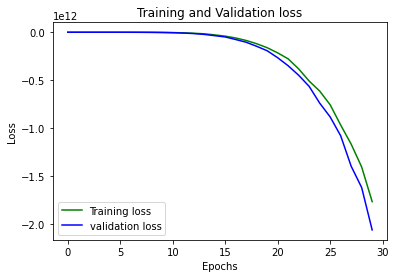

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 activation_25 (Activation)  (None, 148, 148, 64)      0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 72, 72, 64)        36928     
                                                                 
 activation_26 (Activation)  (None, 72, 72, 64)        0         
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                

In [107]:
print('--> Training Conv-Conv-Conv-FC ver 1 ...')
model = CNN_3Conv_1FC(convs=64, dims=3, epochs=30, batch_size=64, drop_rate=0.9, input_shape= input_shape)
print(model.summary())

# Save the weights and the full model
print('---> Save model ...')
model.save(os.path.join(modelFolder,'model3_1_Conv-Conv-Conv-FC_weigths.h5'))
print('Done!')

In [108]:
# # Dimensions of our images
img_width, img_height = 150, 150

# # Train & validation folders
train_data_dir      = project_path + '/data/train'
validation_data_dir = project_path + '/data/validation'

# # Folder to save the models
modelFolder = 'saved_models'

# # Sample parameters
nb_train_samples      = 910 # number of training images (all classes)
nb_validation_samples = 302 # number of validation images (all classes)

# # Initial training params from the previous small CNN script
epochs     = 50 # training epochs
batch_size = 64 # batch size for training

**VGG16**

In [109]:
# Training results for our dataset using pre-trained VGG16 (Convolutional layers only, without top FC)
bottleneck_features_train_path = project_path+'/saved_models/transferVGG16_bottleneck_features_train.npy'

# Validation results for our dataset using pre-trained VGG16 (Convolutional layers only, without top FC)
bottleneck_features_validation_path = project_path+'/saved_models/transferVGG16_bottleneck_features_validation.npy'

# Top top model weights to used for future calculations for layer initialization
top_model_weights_path = project_path+'/saved_models/transferVGG16_bottleneck_fc_model.h5'

# Earlystoping saved model
earlystoping_path = project_path+'/saved_models/transferVGG16_earlystop_model.h5'

In [114]:
def save_bottlebeck_features(batch_size):
    # Calculate the outputs for training and validations sets using bottom pre-trained VGG16
    # Input: batch_size - it will be used to save to file
    # Output: number of the examples for the saved outputs (it could be different from the original dataset!)
    
    # set numpy and tensorflow seeds for reproductibility
    seed(1)            # numpy seed
    set_seed(2) # tensorflow seed
    
    # No data augmentation!
    datagen = ImageDataGenerator(rescale=1. / 255)
    
    # Build the VGG16 network - get VGG16 trained for imagenet without the top layer
    model = applications.vgg16.VGG16(include_top=False, weights='imagenet')
    # model = applications.resnet50.ResNet50(include_top=False, weights='imagenet')

    # Generate training data from train folder
    # generator = datagen.flow_from_directory(
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
  
    # Calculate the output of bottom VGG16 using training data
    bottleneck_features_train = model.predict_generator(
            generator, nb_train_samples // batch_size)
    # Save the traing outputs
    np.save(bottleneck_features_train_path, bottleneck_features_train)

    # Generate validation data from train folder
    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
            
    # Calculate the output of bottom VGG16 using validation data
    bottleneck_features_validation = model.predict_generator(
            generator, nb_validation_samples // batch_size)
    
    # Save the validation outputs
    np.save(bottleneck_features_validation_path, bottleneck_features_validation)
    return (bottleneck_features_train.shape[0], bottleneck_features_validation.shape[0]) # return the new shapes if modified


In [115]:
nb_train_samples, nb_validation_samples = save_bottlebeck_features(batch_size=64)

Found 910 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


Found 302 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


In [116]:
print('New no of train samples      = ', nb_train_samples)
print('New no of validation samples = ', nb_validation_samples)

New no of train samples      =  896
New no of validation samples =  256


In [117]:
def train_top_model(epochs, batch_size, optimizer, drop_rate, summary):
    # Training top model
    # Input:
    # - epochs = no of training epochs
    # - batch_size = size of sample batch during training
    # - optimizer = string to define the optimizer (ex: 'adam', 'optimizers.RMSprop(lr=2e-4)')
    # - drop_rate = rate of dropped neurons
    # - callbacks = list of callbacks options
    # - summary = if True, show the model summary (True, False)
    
    # set numpy and tensorflow seeds for reproductibility
    #seed(1)            # numpy seed
    #set_random_seed(2) # tensorflow seed
    
    # Load training outputs from the pre-trained bottom VGG16
    train_data   = np.load(bottleneck_features_train_path)
    train_labels = np.array([0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))

    # Load training outputs from the pre-trained bottom VGG16
    validation_data   = np.load(bottleneck_features_validation_path)
    validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

    # Construct the top model using two parts: outputs from the bottom VGG16 + a FC layer
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(drop_rate))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the graph
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Fit the model using the live plot of the loss
    history = model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              verbose = 1,
              )
    # Save the final model
    model.save_weights(top_model_weights_path)

    # Print model summary
    if summary == True:
        model.summary()
    
    # Evaluate final test loss and accuracy scores
    score_val = model.evaluate(validation_data, validation_labels, verbose=0)
    score_tr  = model.evaluate(train_data, train_labels, verbose=0)
    print('Train loss    :', score_tr[0])
    print('Train accuracy:', score_tr[1])
    print('Validation loss    :', score_val[0])
    print('Validation accuracy:', score_val[1])

    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(0,epochs)
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return model


Epoch 1/50
28/28 [==============================] - 12s 11ms/step - loss: 0.5531 - accuracy: 0.7277 - val_loss: 0.5237 - val_accuracy: 0.6797
Epoch 2/50
28/28 [==============================] - 0s 6ms/step - loss: 0.3154 - accuracy: 0.8638 - val_loss: 0.4913 - val_accuracy: 0.7969
Epoch 3/50
28/28 [==============================] - 0s 6ms/step - loss: 0.2757 - accuracy: 0.8795 - val_loss: 0.4355 - val_accuracy: 0.7852
Epoch 4/50
28/28 [==============================] - 0s 6ms/step - loss: 0.2124 - accuracy: 0.9196 - val_loss: 0.4520 - val_accuracy: 0.8086
Epoch 5/50
28/28 [==============================] - 0s 6ms/step - loss: 0.1975 - accuracy: 0.9185 - val_loss: 0.4911 - val_accuracy: 0.8047
Epoch 6/50
28/28 [==============================] - 0s 6ms/step - loss: 0.1816 - accuracy: 0.9174 - val_loss: 0.4866 - val_accuracy: 0.8125
Epoch 7/50
28/28 [==============================] - 0s 6ms/step - loss: 0.1619 - accuracy: 0.9342 - val_loss: 0.4177 - val_accuracy: 0.7930
Epoch 8/50
28/28 [

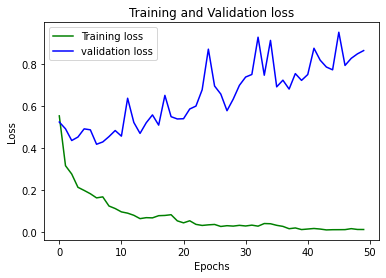

In [118]:
epochs     = 50
batch_size = 32 # this value should be the same with the one used for save_bottlebeck_features()
optimizer  = 'adam'
drop_rate  = 0.5

summary    = True # for the first time show the summary of the trained top model

veg = train_top_model(epochs, batch_size, optimizer, drop_rate, summary)

Found 910 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


Found 302 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


Epoch 1/30
14/14 [==============================] - 1s 20ms/step - loss: 0.8784 - accuracy: 0.5949 - val_loss: 0.5662 - val_accuracy: 0.6641
Epoch 2/30
14/14 [==============================] - 0s 8ms/step - loss: 0.5764 - accuracy: 0.6987 - val_loss: 0.5302 - val_accuracy: 0.7461
Epoch 3/30
14/14 [==============================] - 0s 8ms/step - loss: 0.5387 - accuracy: 0.6987 - val_loss: 0.5087 - val_accuracy: 0.7891
Epoch 4/30
14/14 [==============================] - 0s 8ms/step - loss: 0.4898 - accuracy: 0.7533 - val_loss: 0.4795 - val_accuracy: 0.7734
Epoch 5/30
14/14 [==============================] - 0s 8ms/step - loss: 0.4788 - accuracy: 0.7489 - val_loss: 0.4698 - val_accuracy: 0.7422
Epoch 6/30
14/14 [==============================] - 0s 8ms/step - loss: 0.4495 - accuracy: 0.7857 - val_loss: 0.4579 - val_accuracy: 0.8164
Epoch 7/30
14/14 [==============================] - 0s 8ms/step - loss: 0.4272 - accuracy: 0.7969 - val_loss: 0.4427 - val_accuracy: 0.8008
Epoch 8/30
14/14 [=

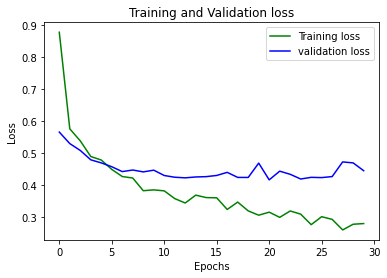

In [119]:

epochs     = 30
batch_size = 64 # this value should be the same with the one used for save_bottlebeck_features()
optimizer  = 'adam'
drop_rate  = 0.9

summary    = False # for the first time show the summary of the trained top model

nb_train_samples, nb_validation_samples = save_bottlebeck_features(batch_size)
veg = train_top_model(epochs, batch_size, optimizer, drop_rate, summary)

In [100]:
WINDOW_SIZES = [150]      # using only one size for the sliding window
window_sizes=WINDOW_SIZES 
step=10                   # step of sliding on the input image (how to divide the original image)

In [103]:
model = veg
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_15 (Flatten)        (None, 8192)              0         
                                                                 
 dense_30 (Dense)            (None, 256)               2097408   
                                                                 
 dropout_15 (Dropout)        (None, 256)               0         
                                                                 
 dense_31 (Dense)            (None, 1)                 257       
                                                                 
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


Input image size= 288 384


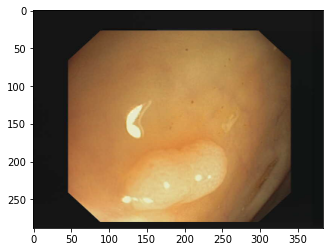

In [86]:

img = skimage.io.imread('/content/drive/MyDrive/Colab Notebooks/polyp segmentation/testImage.tif', plugin='tifffile') # load a test image
print('Input image size=',img.shape[0],img.shape[1])
plt.figure()
plt.imshow(img)
plt.show()

In [ ]:
max_pred = 0.0 # maximum prediction
max_box = []   # box for the polyp detection

print('--> Searching for a colonoscopy polyp ...')
# Loop window sizes: I will use only 150x150
for win_size in window_sizes:
    # Loop on both dimensions of the image
    for top in range(0, img.shape[0] - win_size + 1, step):
        for left in range(0, img.shape[1] - win_size + 1, step):
            # compute the (top, left, bottom, right) of the bounding box
            box = (top, left, top + win_size, left + win_size)

            # crop the original image
            cropped_img = img[box[0]:box[2], box[1]:box[3],:]
            
            # normalize the cropped image (the same processing used for the CNN dataset)
            cropped_img = cropped_img * 1./255
            # reshape from (150, 150, 3) to (1, 150, 150, 3) for prediction
            cropped_img = cropped_img.reshape((1, cropped_img.shape[0], cropped_img.shape[1], cropped_img.shape[2]))

            # make a prediction for only one cropped small image 
            preds = model.predict(cropped_img, batch_size=None, verbose=0)
            # print(box[0],box[2],box[1],box[3], preds[0][0])
            if preds[0][0]> max_pred:
                max_pred = preds[0][0]
                max_box = box
print('Done!')

--> Searching for a colonoscopy polyp ...
Done!


Best prediction: (130, 120, 280, 270) 0.99809307


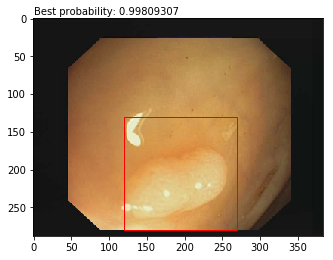

In [ ]:
print('Best prediction:', max_box, max_pred)
plt.figure()
plt.imshow(img)
plt.text(1, -5, 'Best probability: '+str(max_pred), fontsize=10)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((max_box[1], max_box[0]), 150, 150,linewidth=1,edgecolor='r',facecolor='none'))
plt.show()